In [1]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df1 = pd.read_csv('train.csv',index_col = 0)
df2 = pd.read_csv('test.csv',index_col = 0)

In [3]:
df1.head()

,review,sentiment
0,Homelessness (or Houselessness as George Carli...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [4]:
df2.head()

,review,sentiment
0,Actor turned director Bill Paxton follows up h...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


In [5]:
df1 = df1.drop_duplicates(subset="review", keep='first', inplace=False)
df2 = df2.drop_duplicates(subset="review", keep='first', inplace=False)

In [6]:
len(df2)

24799

In [7]:
reviews_train = list(df1['review'])
reviews_test = list(df2['review'])

In [8]:
#remove irrelavant words/numbers/symbols
def remove_num_name(corpus):
    news=[]
    for i in corpus:
        new=i.replace('\n','').replace('\\','').replace('<','').replace('/','').replace('>','').replace('_','')           # remove delimeter 
        new=re.sub(r'[0-9]+','',new)                      # remove numbers
        #new=re.sub(r'[A-Z][a-z]*[\s-][A-Z][a-z]*','',new) # remove full name
        #new=re.sub(r'[A-Z][a-z]+','',new)                 # remove part of name
        news.append(new)
    return news

In [9]:
reviews_train = remove_num_name(reviews_train)
reviews_test = remove_num_name(reviews_test)

In [10]:
lemmatizer = WordNetLemmatizer()
# make a function that takes in a full sentence, tokenizes it, lemmatizes the words, then joins it back
# on white space
def lemmatize_sentence(sentence):
    words = word_tokenize(sentence)
    res_words = []
    for word in words:
        res_words.append(lemmatizer.lemmatize(word).strip(string.punctuation)) 
    return ' '.join(res_words)

In [11]:
lemma_reviews_train = []
lemma_reviews_test = []

for i in reviews_train:
    lemma_reviews_train.append(lemmatize_sentence(i))
    
for i in reviews_test:
    lemma_reviews_test.append(lemmatize_sentence(i))

In [12]:
Y_train = df1[['sentiment']]
Y_test = df2[['sentiment']]

In [13]:
stop=stopwords.words('english')+['movie','film','best','ever','good','one','well',\
                                  'favorite','worse','waste','bad','worst','look','like',\
                                 'many','acting','seen','great','would','great','get','give',\
                                 'would','could','hand']

## Tf-idf & Logistic Regression

In [14]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),\
                             max_df = 0.6,\
                             min_df = 1,\
                             token_pattern=r'\b[a-zA-Z]{3,20}\b',\
                             stop_words=stop,max_features=2500)
# vectorize the corpus
vector_train = vectorizer.fit_transform(lemma_reviews_train)
vector_test = vectorizer.fit_transform(lemma_reviews_test)
X_train = pd.DataFrame(vector_train.toarray(),columns=vectorizer.get_feature_names())
X_test = pd.DataFrame(vector_test.toarray(),columns=vectorizer.get_feature_names())
X_train.shape

(24902, 2500)

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,Y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
y_probs = lr.predict_proba(X_test)
y_probs

array([[0.56280024, 0.43719976],
       [0.66049122, 0.33950878],
       [0.56088134, 0.43911866],
       ...,
       [0.73708187, 0.26291813],
       [0.79032647, 0.20967353],
       [0.68482515, 0.31517485]])

In [19]:
from sklearn import metrics
import numpy as np
fpr, tpr, thresholds = metrics.roc_curve(np.array(Y_test),y_probs[:,1], pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
roc_auc

0.6068450543506682

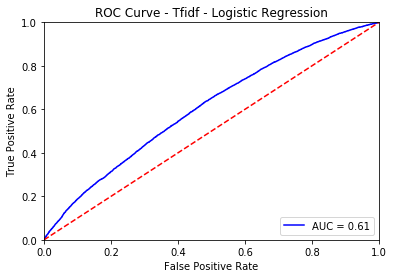

In [21]:
import matplotlib.pyplot as plt
plt.plot(fpr,tpr, 'b',label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve - Tfidf - Logistic Regression')
plt.show()

In [22]:
coefficients = lr.coef_
coefficients

array([[ 0.12848341, -1.0938349 ,  1.4257172 , ...,  0.08965728,
        -0.70290462, -0.76592059]])

In [23]:
feature_importance = pd.Series(coefficients[0],index = X_train.columns)
ordered_feature_importance_pos = feature_importance[feature_importance>0].sort_values(ascending=False)
ordered_feature_importance_neg = feature_importance[feature_importance<0].sort_values()
ordered_feature_importance_pos[:5]

everything     6.129544
period         4.871775
wonderfully    4.829973
amazingly      4.394239
loud           3.995295
dtype: float64

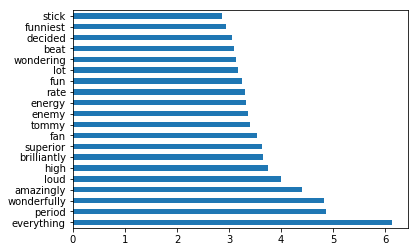

In [24]:
ordered_feature_importance_pos[:20].plot.barh()
plt.show()

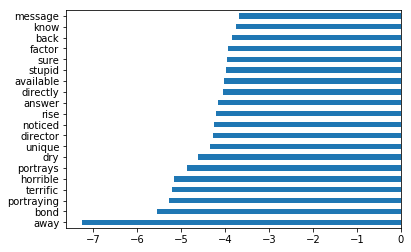

In [26]:
ordered_feature_importance_neg[:20].plot.barh()
plt.show()

## K-means clustering

In [52]:
stop=stopwords.words('english')+['movie','film','best','ever','good','one','well',\
                                  'favorite','worse','waste','bad','worst','look','like',\
                                 'many','acting','seen','great','would','great','get','give',\
                                 'would','could','hand','see','time','year','also','make',\
                                 'also','saw','time','still']

In [53]:
vectorizer_cluster = TfidfVectorizer(ngram_range=(1,1),\
                                     max_df = 0.5,\
                                     token_pattern=r'\b[a-zA-Z]{5,20}\b',\
                                     stop_words=stop,max_features=2500)
# vectorize the corpus
vector = vectorizer_cluster.fit_transform(lemma_reviews_train)
X_cluster = pd.DataFrame(vector.toarray(),columns=vectorizer_cluster.get_feature_names())
X_cluster.shape

(24902, 2500)

### Positive reviews

In [54]:
X_pos = X_cluster[np.array(Y_train['sentiment']==1)]

In [68]:
## Find the best K for positive sentiment
from sklearn.metrics import silhouette_score
Sum_of_squared_distances_pos = []
K = range(5,18)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1,random_state=1000,algorithm='full')
    km = km.fit(X_pos)
    Sum_of_squared_distances_pos.append(km.inertia_)
    label = km.labels_
    sil_coeff = silhouette_score(X_pos, label, metric = 'euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(k, sil_coeff))

For n_clusters=5, The Silhouette Coefficient is 0.0026607559884136316
For n_clusters=6, The Silhouette Coefficient is 0.0029759020479289094
For n_clusters=7, The Silhouette Coefficient is 0.002836477494435688
For n_clusters=8, The Silhouette Coefficient is 0.0036058417235418816
For n_clusters=9, The Silhouette Coefficient is 0.0038333397558021104
For n_clusters=10, The Silhouette Coefficient is 0.003414188748259361
For n_clusters=11, The Silhouette Coefficient is 0.0038658959683047145
For n_clusters=12, The Silhouette Coefficient is 0.004082655470455615
For n_clusters=13, The Silhouette Coefficient is 0.004044121069936238
For n_clusters=14, The Silhouette Coefficient is 0.004561654571578367
For n_clusters=15, The Silhouette Coefficient is 0.004885117181965697
For n_clusters=16, The Silhouette Coefficient is 0.004822017602844256
For n_clusters=17, The Silhouette Coefficient is 0.005105529410174252


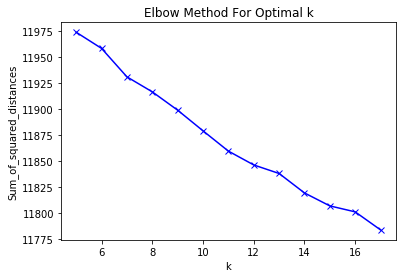

In [69]:
plt.plot(K, Sum_of_squared_distances_pos, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [70]:
from sklearn.cluster import KMeans
import numpy as np

num_clusters = 12
 
km_pos = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1,\
            random_state=1000,algorithm='full')

%time km_pos.fit(X_pos)

clusters = km_pos.labels_.tolist()

CPU times: user 15.4 s, sys: 295 ms, total: 15.7 s
Wall time: 7.96 s


In [81]:
print("Top terms per cluster:")
order_centroids_pos = km_pos.cluster_centers_.argsort()[:, ::-1]
terms_pos = vectorizer_cluster.get_feature_names()
for i in range(num_clusters):
    print(f"Cluster {i}"),
    for ind in order_centroids_pos[i, :10]:
        print(terms_pos[ind],end=' '),
    print('\n')

Top terms per cluster:
Cluster 0
animation disney animated cinderella story character bakshi voice child little 

Cluster 1
world people scene first character woman young never little story 

Cluster 2
story character people little beautiful scene first really think wonderful 

Cluster 3
horror creepy zombie really story house slasher scary scene director 

Cluster 4
action scene fight bourne jackie story martial character really sequence 

Cluster 5
family father mother child brother young story character parent daughter 

Cluster 6
comedy funny laugh hilarious watch romantic character funniest really scene 

Cluster 7
series episode character first original season story watch think really 

Cluster 8
really think character watch people thing scene first thought little 

Cluster 9
episode season series first character really columbo story watch think 

Cluster 10
performance music musical actor character scene dance story oscar wonderful 

Cluster 11
excellent version story performanc

In [82]:
frame_pos = pd.DataFrame(clusters,columns=['group'])

In [83]:
frame_pos.groupby('group')['group'].count()

group
0      307
1     4006
2     1038
3      506
4      483
5      754
6      953
7      343
8     1671
9      326
10    1360
11     724
Name: group, dtype: int64

In [108]:
X_pos.loc[:,'Cluster_Group'] = clusters

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [109]:
pos_group = X_pos.groupby('Cluster_Group').sum().transpose()
pos_group.head()

Cluster_Group,0,1,2,3,4,5,6,7,8,9,10,11
abandoned,0.238088,4.833884,0.451943,1.504723,0.189608,1.187654,0.432910,0.083476,0.673075,0.292880,0.821791,0.965534
ability,0.905905,8.119622,3.150454,0.949321,1.281501,1.435991,1.848082,0.698266,4.757160,0.765042,3.770974,1.246423
absolute,1.294322,8.255033,0.299029,1.298474,0.332741,0.762369,2.121049,0.672191,1.129141,1.205066,2.748531,0.520341
absolutely,1.515396,14.988931,4.226500,2.574022,1.556338,3.093195,6.169863,2.211430,15.014273,2.337501,12.207613,4.032761
absurd,0.034877,4.092898,0.406615,0.858082,0.310376,1.046798,1.060259,0.000000,1.052556,0.194481,0.741934,0.542564


In [117]:
for i in range(12):
    print(f'group{i} {pos_group.loc[:,i].sort_values(ascending=False).head(15)}')

group0 animation     48.532183
disney        45.419061
animated      19.831623
cinderella    17.330787
story         14.790318
character     13.225536
bakshi        11.815163
voice         10.322878
child         10.049323
little         8.356172
music          7.785941
version        7.764446
watch          7.070372
really         7.014280
first          7.001950
Name: 0, dtype: float64
group1 world          87.218386
people         83.447752
scene          75.780126
first          75.140978
character      69.832719
woman          63.406111
young          63.253160
never          60.022977
little         57.096909
story          55.345651
watch          54.168593
thing          53.536561
documentary    51.838668
director       49.695446
another        46.519597
Name: 1, dtype: float64
group2 story        168.265900
character     39.104531
people        28.612665
little        22.853635
beautiful     22.569824
scene         20.862116
first         20.753243
really        20.603516
thin

### Use the negative reviews

In [89]:
## reset the stop words for negative reviews
stop=stopwords.words('english')+['movie','film','best','ever','good','one','well',\
                                  'favorite','worse','waste','bad','worst','look','like',\
                                 'many','acting','seen','great','would','great','get','give',\
                                 'would','could','hand','see','time','year','also','make',\
                                 'also','saw','time','still','think','really','version','thing',\
                                'watch','watching']

In [90]:
vectorizer_cluster2 = TfidfVectorizer(ngram_range=(1,1),\
                                     max_df = 0.5,\
                                     token_pattern=r'\b[a-zA-Z]{5,20}\b',\
                                     stop_words=stop,max_features=2500)
# vectorize the corpus
vector2 = vectorizer_cluster2.fit_transform(lemma_reviews_train)
X_cluster2 = pd.DataFrame(vector2.toarray(),columns=vectorizer_cluster2.get_feature_names())
X_cluster2.shape

(24902, 2500)

In [91]:
X_neg = X_cluster2[np.array(Y_train['sentiment']==0)]

In [102]:
## have a look at different k performance
from sklearn.metrics import silhouette_score
Sum_of_squared_distances = []
K = range(10,19)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    km = km.fit(X_neg)
    Sum_of_squared_distances.append(km.inertia_)
    label = km.labels_
    sil_coeff = silhouette_score(X_neg, label, metric = 'euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(k, sil_coeff))

For n_clusters=10, The Silhouette Coefficient is 0.0031168646212235904
For n_clusters=11, The Silhouette Coefficient is 0.0032539478058072925
For n_clusters=12, The Silhouette Coefficient is 0.003358660380091437
For n_clusters=13, The Silhouette Coefficient is 0.004375771399467042
For n_clusters=14, The Silhouette Coefficient is 0.004830353180810371
For n_clusters=15, The Silhouette Coefficient is 0.004505245554849951
For n_clusters=16, The Silhouette Coefficient is 0.004930039094482833
For n_clusters=17, The Silhouette Coefficient is 0.004276784654101922
For n_clusters=18, The Silhouette Coefficient is 0.005479109918120657


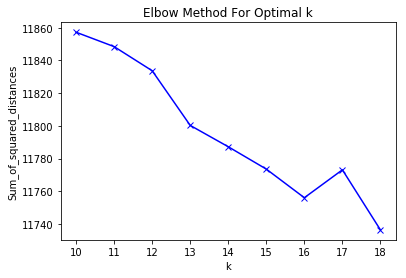

In [104]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [105]:
num_clusters = 10
 
km_neg = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1,\
            random_state=1000,algorithm='full')

%time km_neg.fit(X_neg)

clusters_neg = km_neg.labels_.tolist()

CPU times: user 9.79 s, sys: 295 ms, total: 10.1 s
Wall time: 5.23 s


In [106]:
print("Top terms per cluster:")
order_centroids_neg = km_neg.cluster_centers_.argsort()[:, ::-1]
terms_neg = vectorizer_cluster.get_feature_names()
for i in range(num_clusters):
    print(f"Cluster {i}"),
    for ind in order_centroids_neg[i, :10]:
        print(terms_neg[ind],end=' '),
    print('\n')

Top terms per cluster:
Cluster 0
oscar series remember fired strangely chaplin bette class scheme notion 

Cluster 1
horrific scheme scenery blonde killer flesh strangely buddy godfather eerie 

Cluster 2
activity searching bette director strangely notion scheme horrendous chaplin terror 

Cluster 3
awesome terror activity strangely scheme perfectly chaplin monster nicely actual 

Cluster 4
chaplin scheme strangely notion lived perfectly fired sends political woman 

Cluster 5
zombie horrific scheme perfectly buddy vehicle flawless flesh eerie notion 

Cluster 6
environment servant secretary chaplin fired basis freak strangely carter bette 

Cluster 7
perfectly bette nicely fired scheme strangely lived notion somewhere mirror 

Cluster 8
funniest comedic laugh perfectly scheme humanity chaplin mirror fired bette 

Cluster 9
substance perfectly scheme strangely chaplin fired bette actual nicely terror 



In [100]:
frame_neg = pd.DataFrame(clusters_neg,columns=['group'])

In [101]:
frame_neg.groupby('group')['group'].count()

group
0     535
1     789
2    1310
3     701
4    2310
5     169
6     447
7    4817
8     754
9     599
Name: group, dtype: int64

In [118]:
X_neg.loc[:,'Cluster_Group'] = clusters_neg

In [119]:
neg_group = X_neg.groupby('Cluster_Group').sum().transpose()
neg_group.head()

Cluster_Group,0,1,2,3,4,5,6,7,8,9
abandoned,0.593837,2.491399,0.384785,0.308113,2.947619,0.689278,0.858917,3.709522,0.229507,0.558908
ability,1.668099,1.360829,4.143213,1.046488,6.648218,0.534887,1.232278,12.677816,1.750845,0.926611
absolute,0.919896,2.384508,3.618428,2.245095,4.391706,0.849204,0.484728,9.822058,1.871761,1.510048
absolutely,2.724908,6.350804,13.032065,9.632541,15.060191,1.057852,2.557672,29.702637,8.486263,5.270079
absurd,0.806945,1.410450,2.215452,1.207728,7.397343,0.606371,0.642641,11.281981,2.114650,3.093509


In [121]:
for i in range(10):
    print(f'group{i} {neg_group.loc[:,i].sort_values(ascending=False).head(15)}')

group0 original     104.011822
sequel        31.423358
remake        24.260158
first         23.264719
story         19.210745
character     15.725191
better        13.528181
classic       11.595452
scene         11.520693
nothing       11.054215
little        10.874601
disney        10.463007
people        10.011880
actor          9.857236
never          8.942393
Name: 0, dtype: float64
group1 horror       140.162021
scene         25.643688
scary         24.477674
blood         20.114355
killer        19.969457
flick         19.473836
story         19.370971
budget        19.088621
going         18.523129
effect        17.889302
people        17.584318
better        17.559617
character     17.298645
nothing       17.293378
first         17.206838
Name: 1, dtype: float64
group2 actor          118.969520
script         105.319109
better          44.494048
director        36.471695
story           35.516569
nothing         34.168151
scene           29.136890
horrible        28.796531
cha